## Gradient-Based Explanations of Causal Proxy Model

This notebook generates gradient-based visualizations to show how different representations within a CPM model capture the different aspects that they are trained to represent.

In [1]:
from typing import List
from libs import *
"""
For evaluate, we use a single random seed, as
the models are trained with 5 different seeds
already.
"""
_ = random.seed(123)
_ = np.random.seed(123)
_ = torch.manual_seed(123)

In [2]:
"""
This is another interface for defining CPM.
We later found that there is essentially no
different between this static way versus sampling
on-the-fly for CPM model evaluation. We use
this interface for debiasing as it is easier to
run experiments with.
"""
class StaticCausalProxyModelForBERT(Explainer):
    def __init__(
        self, 
        blackbox_model_path,
        cpm_model_path, 
        device, batch_size, 
        intervention_h_dim=1,
        min_iit_pair_examples=1,
        match_non_int_type=False,
        cache_dir="../../huggingface_cache"
    ):
        self.batch_size = batch_size
        self.device = device
        self.min_iit_pair_examples = min_iit_pair_examples
        self.match_non_int_type = match_non_int_type
        self.intervention_h_dim = intervention_h_dim
        # blackbox model loading.
        self.blackbox_model = BertForNonlinearSequenceClassification.from_pretrained(
            blackbox_model_path,
            use_auth_token=True,
            cache_dir=cache_dir
        )
        self.blackbox_model.to(device)
        
        # causal proxy model loading.
        cpm_config = AutoConfig.from_pretrained(
            cpm_model_path,
            cache_dir=cache_dir,
            use_auth_token=True if "CEBaB/" in cpm_model_path else False,
        )
        try:
            cpm_config.intervention_h_dim = cpm_config.intervention_h_dim
        except:
            cpm_config.intervention_h_dim = intervention_h_dim
        print(f"intervention_h_dim={cpm_config.intervention_h_dim}")
        cpm_model = IITBERTForSequenceClassification.from_pretrained(
            cpm_model_path,
            config=cpm_config,
            cache_dir=cache_dir,
        )
        cpm_model.to(device)
        self.cpm_model = InterventionableIITTransformerForSequenceClassification(
            model=cpm_model
        )
        
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        
        self.clean()
        
    def clean(self):
        self.hidden_repr_static_pool = {}
        for concept in ["ambiance", "food", "noise", "service"]:
            for concept_label in ["Positive", "Negative", "unknown"]:
                self.hidden_repr_static_pool[(concept, concept_label)] = []
        
    def fit(self, 
            dataset, classifier_predictions, 
            classifier, dev_dataset=None,
            reduce=False, control=False,
           ):
        """
        For static CPM model, we need to extract the hidden representations for
        concepts before estimating iCACE scores.
        """
        self.blackbox_model.eval()
        self.cpm_model.model.eval()

        x, y, ambiance_label, food_label, noise_label, service_labal = self.preprocess(dataset)

        # get the predictions batch per batch
        cls_hidden_states = []
        for i in range(ceil(len(dataset) / self.batch_size)):
            x_batch = {k: v[i * self.batch_size:(i + 1) * self.batch_size].to(self.device) for k, v in x.items()}
            if control:
                cls_hidden_state = self.blackbox_model(
                    **x_batch,
                    output_hidden_states=True,
                ).hidden_states[-1][:,0,:].cpu().detach()
            else:
                cls_hidden_state = self.cpm_model.model(
                    **x_batch,
                    output_hidden_states=True,
                ).hidden_states[-1][:,0,:].cpu().detach()
            cls_hidden_states.append(cls_hidden_state)

        cls_hidden_states = torch.concat(cls_hidden_states)
        
        for i in range(0, len(ambiance_label)): 
            if ("ambiance", ambiance_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 0*self.intervention_h_dim
                end_idx = 1*self.intervention_h_dim
                self.hidden_repr_static_pool[("ambiance", ambiance_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
            
            if ("food", food_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 1*self.intervention_h_dim
                end_idx = 2*self.intervention_h_dim
                self.hidden_repr_static_pool[("food", food_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
                
            if ("noise", noise_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 2*self.intervention_h_dim
                end_idx = 3*self.intervention_h_dim
                self.hidden_repr_static_pool[("noise", noise_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
                
            if ("service", service_labal.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 3*self.intervention_h_dim
                end_idx = 4*self.intervention_h_dim
                self.hidden_repr_static_pool[("service", service_labal.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )

        if reduce:
            for k, v in self.hidden_repr_static_pool.items():
                self.hidden_repr_static_pool[k] = torch.stack(v, dim=0).mean(dim=0)
        else:
            for k, v in self.hidden_repr_static_pool.items():
                self.hidden_repr_static_pool[k] = torch.stack(v, dim=0)
            
    def preprocess(self, df):
        x = self.tokenizer(df['description'].to_list(), padding=True, truncation=True, return_tensors='pt')
        y = df['review_majority'].astype(int)

        all_type = {
            "ambiance", "food", "noise", "service"
        }
        return x, y, \
            df['ambiance_aspect_majority'], \
            df['food_aspect_majority'], \
            df['noise_aspect_majority'], \
            df['service_aspect_majority']
    
    def preprocess_icace(self, pairs_dataset):
        
        # configs
        iit_pairs_dataset = []
        iit_id = 0
        for index, row in pairs_dataset.iterrows():
            query_description_base = row['description_base']
            query_int_type = row['intervention_type']
            query_int_aspect_base = row["intervention_aspect_base"]
            query_int_aspect_assignment = row['intervention_aspect_counterfactual']
            query_original_id = row["original_id_base"]
            iit_pairs_dataset += [[
                iit_id,
                query_int_type,
                query_description_base, 
                query_int_aspect_base,
                query_int_aspect_assignment
            ]]
            iit_id += 1
        iit_pairs_dataset = pd.DataFrame(
            columns=[
                'iit_id',
                'intervention_type', 
                'description_base', 
                'intervention_aspect_base',
                'intervention_aspect_counterfactual'], 
            data=iit_pairs_dataset
        )
        
        base_x = self.tokenizer(
            iit_pairs_dataset['description_base'].to_list(), 
            padding=True, truncation=True, return_tensors='pt'
        )

        intervention_corr = []
        source_x = []
        for i in range(len(iit_pairs_dataset["intervention_type"])):
            _type = iit_pairs_dataset["intervention_type"].iloc[i]
            _base_label = iit_pairs_dataset["intervention_aspect_base"].iloc[i]
            _label = iit_pairs_dataset["intervention_aspect_counterfactual"].iloc[i]
            if _type == "ambiance":
                intervention_corr += [0]
            if _type == "food":
                intervention_corr += [1]
            if _type == "noise":
                intervention_corr += [2]
            if _type == "service":
                intervention_corr += [3]
                
            """
            UNCOMMENT TO TRY:
            
            Just to try out if we actually care about the difference.
            This will need some modifications on the modeling files as well
            to consume this as a delta, not activation replacement.
            """
            # source_x += [
            #     self.hidden_repr_static_pool[(_type, _label)] - \
            #         self.hidden_repr_static_pool[(_type, _base_label)]
            # ]
            
            hidden_repr_static_pool = self.hidden_repr_static_pool[(_type, _label)]
            hidden_repr_static_sampled = hidden_repr_static_pool[random.randrange(hidden_repr_static_pool.shape[0])]
            source_x += [hidden_repr_static_sampled]
            
        source_x = torch.stack(source_x, dim=0)
        intervention_corr = torch.tensor(intervention_corr).long()
        return base_x, source_x, intervention_corr, iit_pairs_dataset
    
    def estimate_icace(self, pairs):
        
        CPM_iTEs = []
        self.blackbox_model.eval()
        self.cpm_model.model.eval()
        base_x, source_x, intervention_corr, iit_pairs_dataset = self.preprocess_icace(
            pairs,
        )
        with torch.no_grad():
            for i in tqdm(range(ceil(len(iit_pairs_dataset)/self.batch_size))):
                base_x_batch = {k:v[i*self.batch_size:(i+1)*self.batch_size].to(self.device) for k,v in base_x.items()} 
                source_x_batch = source_x[i*self.batch_size:(i+1)*self.batch_size].to(self.device)
                intervention_corr_batch = intervention_corr[i*self.batch_size:(i+1)*self.batch_size].to(self.device)
                
                base_outputs = torch.nn.functional.softmax(
                    self.blackbox_model(**base_x_batch).logits.cpu(), dim=-1
                ).detach()
                _, _, counterfactual_outputs = self.cpm_model.forward_with_hook(
                    base=(base_x_batch['input_ids'], base_x_batch['attention_mask']),
                    source_hidden_reprs=source_x_batch,
                    base_intervention_corr=intervention_corr_batch,
                    source_intervention_corr=intervention_corr_batch,
                )
                counterfactual_outputs = torch.nn.functional.softmax(
                    counterfactual_outputs["logits"][0].cpu(), dim=-1
                ).detach()
                CPM_iTE = counterfactual_outputs-base_outputs
                CPM_iTEs.append(CPM_iTE)
        CPM_iTEs = torch.concat(CPM_iTEs)
        CPM_iTEs = np.round(CPM_iTEs.numpy(), decimals=4)

        # only for iit explainer!
        iit_pairs_dataset["EiCaCE"] = list(CPM_iTEs)
        CPM_iTEs = list(iit_pairs_dataset.groupby(["iit_id"])["EiCaCE"].mean())
        
        return CPM_iTEs
    

In [3]:
seed=42
class_num=5
beta=1.0
gemma=3.0
h_dim=192
dataset_type = f'{class_num}-way'
correction_epsilon=None
cls_dropout=0.1
enc_dropout=0.1
control=False
model_arch="bert-base-uncased"
if model_arch == "bert-base-uncased":
    model_path = "BERT-control-results" if control else "BERT-results"
elif model_arch == "roberta-base":
    model_path = "RoBERTa-control-results" if control else "RoBERTa-results"
elif model_arch == "gpt2":
    model_path = "gpt2-control-results" if control else "gpt2-results"
elif model_arch == "lstm":
    model_path = "lstm-control-results" if control else "lstm-results"

# NOTE: edited the device for personal use (should switch to your intended GPU/CPU device)
device='cuda:0'
batch_size=32
    
blackbox_model_path = f'CEBaB/{model_arch}.CEBaB.sa.{class_num}-class.exclusive.seed_{seed}'
if control:
    cpm_model_path = blackbox_model_path
else:
    # NOTE: slightly edited the CPM model path (should add model_arch folder back into path)
    cpm_model_path = f'../proxy_training_results/'\
                       f'cebab.train.train.alpha.1.0'\
                       f'.beta.{beta}.gemma.{gemma}.dim.{h_dim}.hightype.'\
                       f'{model_arch}.Proxy.'\
                       f'CEBaB.sa.{class_num}-class.exclusive.'\
                       f'mode.align.cls.dropout.{cls_dropout}.enc.dropout.{enc_dropout}.seed_{seed}'
# load data from HF 
cebab = datasets.load_dataset(
    'CEBaB/CEBaB', use_auth_token=True,
    # cache_dir="../../huggingface_cache/"
)

cebab['train'] = cebab['train_exclusive']
train, dev, test = preprocess_hf_dataset(
    cebab, one_example_per_world=False, 
    verbose=1, dataset_type=dataset_type
)

train_dataset = train.copy()
dev_dataset = test.copy()

Using custom data configuration CEBaB--CEBaB-65fc31a444dff443
Reusing dataset parquet (C:\Users\amirz\.cache\huggingface\datasets\CEBaB___parquet\CEBaB--CEBaB-65fc31a444dff443\0.0.0\7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.03% of train dataset.


In [4]:
# loading for control
cpm_control_explainer = StaticCausalProxyModelForBERT(
    blackbox_model_path,
    blackbox_model_path, 
    device=device, 
    batch_size=batch_size,
    intervention_h_dim=h_dim,
)
cpm_control_explainer.clean()
cpm_control_explainer.fit(
    train_dataset, 
    None, None, None,
    reduce=False, control=True,
)

# loading for cpm (same way but different usages)
cpm_explainer = StaticCausalProxyModelForBERT(
    blackbox_model_path,
    os.path.abspath(cpm_model_path), 
    device=device, 
    batch_size=batch_size,
    intervention_h_dim=h_dim,
)
cpm_explainer.clean()
cpm_explainer.fit(
    train_dataset, 
    None, None, None,
    reduce=False, control=False,
)

intervention_h_dim=192


Some weights of IITBERTForSequenceClassification were not initialized from the model checkpoint at CEBaB/bert-base-uncased.CEBaB.sa.5-class.exclusive.seed_42 and are newly initialized: ['multitask_classifier.dense.bias', 'multitask_classifier.out_proj.bias', 'multitask_classifier.dense.weight', 'multitask_classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


intervention_h_dim=192


c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [13]:
def tokenize_sentence(sentence, explanator):
    """
    Tokenize the sentence using the `explanator` tokenizer
    """
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()
    is_split_into_words = isinstance(sentence, List)
    # Original ratings.
    x = explanator.tokenizer([sentence], padding=True, truncation=True, return_tensors='pt', is_split_into_words=is_split_into_words)
    x_batch = {k: v.to(explanator.device) for k, v in x.items()}
    return x_batch

In [14]:
def explain_logits_with_gradients(sentence, explanator, aspect=0):
    """
    Applies a saliency map on the logits of the output of the `explanator` 
    model when run on a single input sentence. It uses the tokens produced by
    the `explanator` tokenizer to determine which parts of the input had the
    most influence on the chosen logit.

    aspect : int
        Chooses which output to focus on, from the following:
        0 - overall review
        1 - ambiance
        2 - food
        3 - noise
        4 - service
    """
    explanator.blackbox_model.eval()
    explanator.blackbox_model.zero_grad()
    explanator.cpm_model.model.eval()
    explanator.cpm_model.model.zero_grad()

    x = tokenize_sentence(sentence, explanator)
    outputs = explanator.cpm_model.model(
        **x,
        output_hidden_states=True,
    )

    outputs.hidden_states[0].retain_grad()

    classification = outputs.logits[aspect].argmax()
    output_max = outputs.logits[aspect][0, classification]
    output_max.backward()
    saliency, _ = torch.max(outputs.hidden_states[0].grad.data.abs(), dim=-1)
    grad_df = pd.DataFrame({
        'word': explanator.tokenizer.convert_ids_to_tokens(x['input_ids'][0]),
        'weight': saliency.detach().cpu()[0]
    })

    _ = sns.barplot(data=grad_df, x='word', y='weight')
    _ = plt.xticks(rotation=90)


In [15]:
def softmax(x):
    e_x = np.exp(x - x.max())
    return e_x / np.sum(e_x)

In [8]:
def compute_saliency_of_final_layer(model, x, explanator, aspect=None):
    """
    Computes gradient-based saliency of how the input features affect 
    the computation of the final layer of the CPM model, which is used to
    predict the overall sentiment of a sentence.

    model
        model to explain (either cpm_model.model or blackbox_model)
    x
        tokenized sentence to explain
    explanator
        CPM model
    aspect : int
        Different aspects correspond to different slices of the 
        final model layer. The options are:
        0 - ambiance
        1 - food
        2 - noise
        3 - service
        None - all of the above (for control)
    """
    # zero gradients
    model.eval()
    model.zero_grad()

    # compute output
    outputs = model(
        **x,
        output_hidden_states=True,
    )
    outputs.hidden_states[0].retain_grad()

    # get slice of final layer that corresponds to aspect provided
    if aspect is not None:
        start_idx = aspect*explanator.intervention_h_dim
        end_idx = (aspect+1)*explanator.intervention_h_dim
    else:
        start_idx = 0
        end_idx = outputs.hidden_states[-1].size(2)
    
    # run gradient backwards for the final layer,
    # only computing the gradients for the range of the specified aspect
    output_grad = outputs.hidden_states[-1]
    mask = torch.zeros_like(output_grad)
    mask[:, 0, start_idx:end_idx] = 1
    output_grad.backward(gradient=mask)

    # get gradient at input layer
    saliency, _ = torch.max(outputs.hidden_states[0].grad.data.abs(), dim=-1)
    return saliency.detach().cpu().numpy()[0]

In [9]:
def compute_weighted_saliency(model, x, explanator, aspect=None):
    """
    Computes the gradient-based saliency of the output logits,
    through the specified slice of the final layer of the CPM model.
    Corresponds to
    dy/d(aspect representation) * d(aspect representation)/dx

    model
        model to explain (either cpm_model.model or blackbox_model)
    x
        tokenized sentence to explain
    explanator
        CPM model
    aspect : int
        Different aspects correspond to different slices of the 
        final model layer. The options are:
        0 - ambiance
        1 - food
        2 - noise
        3 - service
        None - all of the above (for control)
    """
    # zero gradients
    model.eval()
    model.zero_grad()

    # compute output
    outputs = model(
        **x,
        output_hidden_states=True,
    )

    # get aspect representation
    if aspect is not None:
        start_idx = aspect*explanator.intervention_h_dim
        end_idx = (aspect+1)*explanator.intervention_h_dim
    else:
        start_idx = 0
        end_idx = outputs.hidden_states[-1].size(2)

    first_layer = outputs.hidden_states[0]
    last_layer = outputs.hidden_states[-1]

    first_layer.retain_grad()

    # compute backwards gradient from final layer to input layer
    mask = torch.zeros_like(last_layer)
    mask[:, 0, start_idx:end_idx] = 1
    last_layer.backward(gradient=mask, retain_graph=True)

    first_layer_gradient = first_layer.grad.data.abs().clone().detach()


    # reset gradients
    model.zero_grad()
    
    last_layer.retain_grad()

    # compute backwards gradient from output logits to final layer
    logits = outputs.logits[0] if isinstance(outputs.logits, tuple) else outputs.logits
    classification = logits.argmax()
    output_max = logits[0, classification]
    output_max.backward(retain_graph=True)

    last_layer_gradient = last_layer.grad.data.abs().clone().detach()

    # multiply gradient at input level with gradient of CLS vector at final layer, 
    # since only this slice is used in computing the output logits
    weighted_gradient = first_layer_gradient * last_layer_gradient[:, 0, :]
    
    saliency, _ = torch.max(weighted_gradient, dim=-1)

    return saliency[0].cpu().numpy()

In [10]:
def explain_interventions_with_gradients(
        sentence, 
        explanator, 
        aspect, 
        normalize=True, 
        softmax_norm=False, 
        control_for_gradient=False, 
        saliency_fn=compute_saliency_of_final_layer
    ):
    """
    Provides gradient-based saliency map to display which tokens 
    had the most effect on the intermediate representations
    encoded by the `explanator.cpm_model` in the final layer.

    sentence : str
        Single input example
    explanator : StaticCausalProxyModelForBERT 
    aspect : int
        Chooses which embedded aspect to focus on.
        0 - ambiance
        1 - food
        2 - noise
        3 - service
    normalize : bool, default True
        Whether to normalize output gradients
    softmax_norm : bool, default False
        Whether to apply softmax function in normalization (by default,
        divide the gradients by their sum)
    control_for_gradient : bool, default False
        Whether to control for the change in gradients by computing 
        saliency both for the particular aspect representation and for 
        the whole final layer (our control), and plotting the difference
        between these
    saliency_fn
        The function to use in order to compute gradient-based saliency
        (right now, either `compute_saliency_of_final_layer` or `compute_weighted_saliency`)
    """
    explanator.blackbox_model.eval()
    explanator.cpm_model.model.eval()

    x = tokenize_sentence(sentence, explanator)
    tokens = explanator.tokenizer.convert_ids_to_tokens(x['input_ids'][0])
    cpm_saliency = saliency_fn(explanator.cpm_model.model, x, explanator, aspect=aspect)
    control_saliency = saliency_fn(explanator.blackbox_model, x, explanator, aspect=aspect)

    if control_for_gradient:
        cpm_control = saliency_fn(explanator.cpm_model.model, x, explanator, aspect=None)
        control_control = saliency_fn(explanator.blackbox_model, x, explanator, aspect=None)
        cpm_saliency = np.abs(cpm_saliency - cpm_control)
        control_saliency = np.abs(control_saliency - control_control)


    cpm_df = pd.DataFrame({
        'word': tokens,
        'weight': cpm_saliency,
        'model': 'CPM'
    })

    control_df = pd.DataFrame({
        'word': tokens,
        'weight': control_saliency,
        'model': 'control'
    })

    if normalize:
        if softmax_norm:
            cpm_df['weight'] = softmax(cpm_df['weight'])
            control_df['weight'] = softmax(control_df['weight'])
        else:
            cpm_df['weight'] = cpm_df['weight'] / cpm_df['weight'].sum()
            control_df['weight'] = control_df['weight'] / control_df['weight'].sum()

    plot_data = pd.concat([cpm_df, control_df])
    g = sns.catplot(
        data=plot_data,
        x='word',
        y='weight',
        col='model',
        kind='bar'
    )
    ax1, ax2 = g.axes[0]
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    # _ = plt.xticks(rotation=90)
    return g, plot_data

### Gradient-Based Visualizations

Graphs visualizations of which parts of the input the CPM model focuses on in representing a certain concept, such as ambiance, food, noise, or service.

In [16]:
example_sentence = 'The music was too loud, and the decorations were tasteless, but they had friendly waiters and delicious pasta'

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


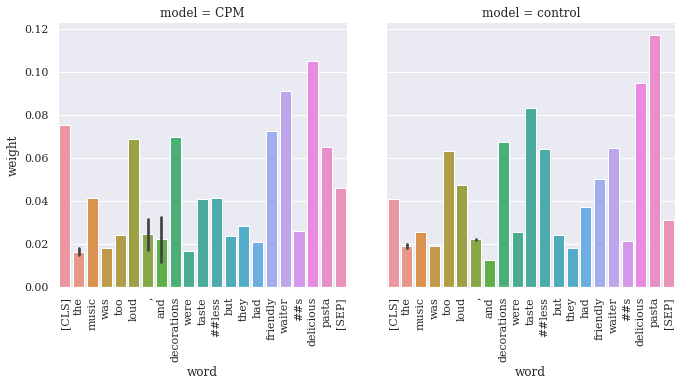

In [34]:
# which tokens influence the representation of ambiance?
_, plot_data = explain_interventions_with_gradients(
    example_sentence, cpm_explainer, 0, normalize=True, softmax_norm=False, control_for_gradient=False, saliency_fn=compute_weighted_saliency
)

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


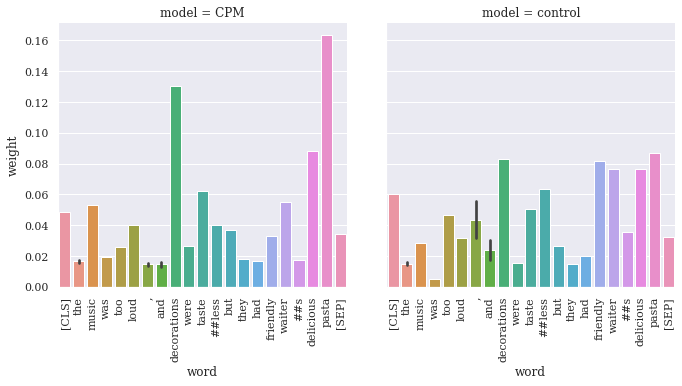

In [26]:
# which tokens influence the representation of food?
_, plot_data = explain_interventions_with_gradients(
    example_sentence, cpm_explainer, 1, normalize=True, softmax_norm=False, control_for_gradient=True, saliency_fn=compute_weighted_saliency
)

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


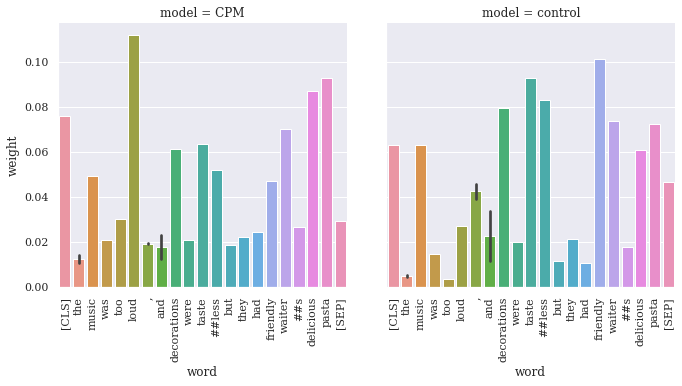

In [23]:
# which tokens influence the representation of noise?
_, plot_data = explain_interventions_with_gradients(
    example_sentence, cpm_explainer, 2, normalize=True, softmax_norm=False, control_for_gradient=True, saliency_fn=compute_weighted_saliency
)

c:\Users\amirz\anaconda3\envs\nlu\lib\site-packages\transformers\modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


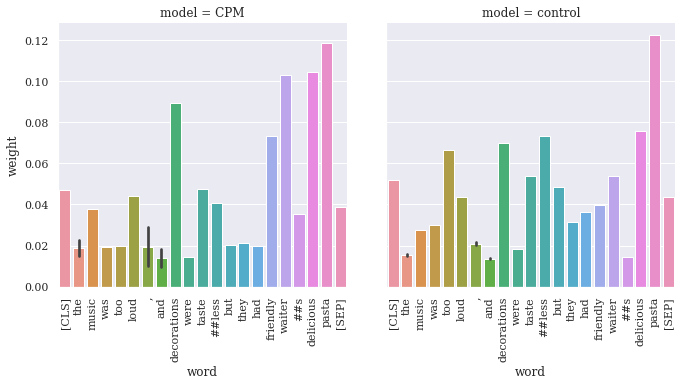

In [36]:
# which tokens influence the representation of service?
_, plot_data = explain_interventions_with_gradients(
    example_sentence, cpm_explainer, 3, normalize=True, softmax_norm=False, control_for_gradient=False, saliency_fn=compute_weighted_saliency
)